# SSD : Single Shot MultiBox Detector

pytorch version of https://gluon.mxnet.io/chapter08_computer-vision/object-detection.html

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F


## Default anchor boxes

+ image shape : 3,w,h
+ sizes : [s1, s2, s3, ... , $s_n$]
+ ratios : [r1, r2, r3, ... , $r_n$]
+ anchor box 
  

In [306]:
def MultiBoxPrior(x ,sizes=[.5, .25, .1], ratios=[1, 2, .5]):
    sizes = torch.Tensor(sizes)
    ratios = torch.Tensor(ratios).sqrt()
    #x : [C,W,H]
    b,w,h = x.data.size()[0],x.data.size()[2],x.data.size()[3]
    n,m = sizes.data.size()[0],ratios.data.size()[0]
    num_priors = n+m-1
    priors = torch.zeros(w, h, num_priors,4)
    w_ = torch.cat((sizes*ratios[0],ratios[1:]*sizes[0]),0)
    h_ = torch.cat((sizes/ratios[0],1./ratios[1:]*sizes[0]),0)
    for j in range(w):
        for k in range(h):
            x_c, y_c = torch.tensor((j+1)/w).expand(num_priors), torch.tensor((1+k)/h).expand(num_priors)
            priors[j][k]  = torch.cat(((x_c[0]-w_/2).view(num_priors,-1),(y_c[0]-h_/2).view(num_priors,-1),
                                       (x_c[0]+w_/2).view(num_priors,-1),(y_c[0]+h_/2).view(num_priors,-1)),1)
    
    #dims = [b,w,h,num_priors,4]
    #priors = priors.expand(tuple(dims))
    return priors.view(b,-1,4)

In [282]:
import time
n = 32
x = torch.randn(1,3,n,n)

start = time.time()
boxes = MultiBoxPrior(x)
end = time.time()
print(end-start)

0.1978590488433838


In [283]:
boxes = boxes.view((n, n, 5, 4))

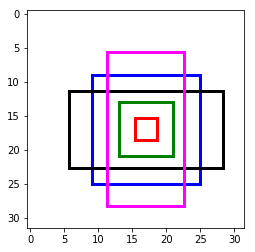

In [284]:
import matplotlib.pyplot as plt
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.numpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]),
        fill=False, edgecolor=color, linewidth=linewidth)
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(torch.ones((n, n, 3)).numpy())
anchors = boxes[n//2, n//2, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

## Predict classes

In [6]:
def class_predictor(in_channel,num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2d(in_channel,num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(3,5, 10)
x = torch.randn(2, 3, 20, 20)
print('Class prediction', cls_pred(x).shape)

Class prediction torch.Size([2, 55, 20, 20])


## Predict anchor box

In [7]:
def box_predictor(in_channel,num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2d(in_channel,num_anchors * 4, 3, padding=1)

box_pred = box_predictor(3,10)
x = torch.randn(2, 3, 20, 20)
print('Box prediction', box_pred(x).shape)

Box prediction torch.Size([2, 40, 20, 20])


## Down sample features

In [200]:
class down_sample(nn.Module):
    def __init__(self, in_channel,num_filters,maxPool = True):
        super(down_sample, self).__init__()
        self.num_filters = num_filters
        self.in_ = [in_channel,num_filters]
        self.maxPool = maxPool
    def forward(self, x):
        for i in range(2):
            x = nn.Conv2d(self.in_[i], self.num_filters, 3,1,padding=1)(x)
            x = nn.BatchNorm2d(self.num_filters)(x)
            x = nn.ReLU(inplace=True)(x)
        if(self.maxPool):
            x = nn.MaxPool2d(2)(x)
        return x
    

blk = down_sample(3,10)
x = torch.randn(2, 3, 20, 20)
print('Before', x.shape, 'after', blk(x).shape)

Before torch.Size([2, 3, 20, 20]) after torch.Size([2, 10, 10, 10])


## Manage preditions from multiple layers

In [259]:
def flatten_prediction(pred):
    batch = pred.shape[0]
    return (pred.permute(0, 2, 3, 1).contiguous().view(batch,-1))

def concat_predictions(preds):
    return torch.cat(tuple([flatten_prediction(p) for p in preds]), 1)
    #return torch.cat(tuple(preds), 1)

In [261]:
y1 = torch.randn(2, 55, 20, 20)
y2 = torch.randn(2, 33, 10, 10)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([y1, y2]).shape)

Flatten class prediction 1 torch.Size([2, 22000])
Flatten class prediction 2 torch.Size([2, 3300])
Concat class predictions torch.Size([2, 25300])


## Body network

In [202]:
def body():
    """return the body network"""
    in_ = [3,16,32,64]
    out_=[16, 32, 64,128]
    return nn.Sequential(down_sample(in_[0],out_[0]),
                         down_sample(in_[1],out_[1]),
                         down_sample(in_[2],out_[2]),
                         down_sample(in_[3],out_[3],False))

bnet = body()
x = torch.randn(2, 3, 256, 256)
print('Body network', [y.shape for y in bnet(x)])

Body network [torch.Size([128, 32, 32]), torch.Size([128, 32, 32])]


## Create a toy SSD model

In [107]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
    def forward(self,x):
        return torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)

In [203]:
def get_blk(i):
    if i == 0:
        blk = body()
    elif i == 4:
        blk = GlobalAvgPool2d()
    else:
        blk = down_sample(128,128) 
    return blk

## Forward

In [307]:
def blk_forward(X, blk, size, ratio, class_predictor, box_predictor):
    Y = blk(X)
    print("out : ",Y.shape)
    anchors = MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_preds = class_predictor(Y)
    bbox_preds = box_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

## All things together

In [308]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79]]
ratios = [[1, 2, 0.5]] * 4
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [311]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(4):
            setattr(self, 'blk_%d' % i, get_blk(i))
            setattr(self, 'cls_%d' % i, class_predictor(128,num_anchors,num_classes))
            setattr(self, 'bbox_%d' % i, box_predictor(128,num_anchors))

    def forward(self, X):
        batch = X.shape[0]
        anchors, cls_preds, bbox_preds = [None] * 4, [None] * 4, [None] * 4
        for i in range(4):
            print(i," forward : ",X.shape)
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, 'blk_%d' % i), sizes[i], ratios[i],
                getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))
            print("X : ",X.shape,
                  "\nanchors : ",anchors[i].shape,
                  "\ncls_preds : ",cls_preds[i].shape,
                  "\nbbox_preds : ",bbox_preds[i].shape,"\n")
    
        return (torch.cat(tuple(anchors), 1).view(1,-1,4),
                concat_predictions(cls_preds).view(batch,-1,self.num_classes+1),
                concat_predictions(bbox_preds))

In [312]:
net = TinySSD(1)
x = torch.randn(8, 3, 256, 256)
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', '\n anchors', default_anchors.shape, 
      '\n class prediction', class_predictions.shape, 
      '\n box prediction', box_predictions.shape)

0  forward :  torch.Size([8, 3, 256, 256])
out :  torch.Size([8, 128, 32, 32])
X :  torch.Size([8, 128, 32, 32]) 
anchors :  torch.Size([8, 512, 4]) 
cls_preds :  torch.Size([8, 8, 32, 32]) 
bbox_preds :  torch.Size([8, 16, 32, 32]) 

1  forward :  torch.Size([8, 128, 32, 32])
out :  torch.Size([8, 128, 16, 16])
X :  torch.Size([8, 128, 16, 16]) 
anchors :  torch.Size([8, 128, 4]) 
cls_preds :  torch.Size([8, 8, 16, 16]) 
bbox_preds :  torch.Size([8, 16, 16, 16]) 

2  forward :  torch.Size([8, 128, 16, 16])
out :  torch.Size([8, 128, 8, 8])
X :  torch.Size([8, 128, 8, 8]) 
anchors :  torch.Size([8, 32, 4]) 
cls_preds :  torch.Size([8, 8, 8, 8]) 
bbox_preds :  torch.Size([8, 16, 8, 8]) 

3  forward :  torch.Size([8, 128, 8, 8])
out :  torch.Size([8, 128, 4, 4])
X :  torch.Size([8, 128, 4, 4]) 
anchors :  torch.Size([8, 8, 4]) 
cls_preds :  torch.Size([8, 8, 4, 4]) 
bbox_preds :  torch.Size([8, 16, 4, 4]) 

Outputs: 
 anchors torch.Size([1, 5440, 4]) 
 class prediction torch.Size([8, 544

### MultiBoxTarget

In [328]:
from box_utils import *

ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

In [330]:
ious = jaccard(anchors,ground_truth[:,1:])
print(ious)

tensor([[0.0536, 0.0000],
        [0.1417, 0.0000],
        [0.0000, 0.5657],
        [0.0000, 0.2059],
        [0.0000, 0.7459]])


In [333]:
ious.max(0)

torch.return_types.max(values=tensor([0.1417, 0.7459]), indices=tensor([1, 4]))

## Training

In [314]:
from data.voc_scut import *

batch_size = 8
dataset = VOCDetection("/Users/seungyoun/Desktop/mAyI/SSD/data/SCUT_HEAD")

dateset init


In [319]:
from torch.nn.init import xavier_uniform_

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

net.apply(init_weights)

TinySSD(
  (blk_0): Sequential(
    (0): down_sample()
    (1): down_sample()
    (2): down_sample()
    (3): down_sample()
  )
  (cls_0): Conv2d(128, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bbox_0): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blk_1): down_sample()
  (cls_1): Conv2d(128, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bbox_1): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blk_2): down_sample()
  (cls_2): Conv2d(128, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bbox_2): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blk_3): down_sample()
  (cls_3): Conv2d(128, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bbox_3): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [322]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

### Loss and Evalutation Function

In [323]:
cls_loss = nn.CrossEntropyLoss()
bbox_loss = nn.SmoothL1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

### Train the Model

In [324]:
def batch_out(pull_idx,batch_size=4):
    batch = []
    annot_ = []
    for i in range(batch_size):
        data = dataset.pull_item(pull_idx)
        img,annot = data[0].permute(2,1,0),data[1]
        batch.append(np.array(img))
        annot_.append(np.array(annot).astype(float))
    batch = np.array(batch)
    batch = torch.Tensor(batch)
    annot_ = np.array(annot_)
    return batch,annot_

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    # accuracy_sum, mae_sum, num_examples, num_labels
    train_iter.reset()
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)

        anchors, cls_preds, bbox_preds = net(X)
        # Label the category and offset of each anchor box
        bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # Calculate the loss function using the predicted and labeled
            # category and offset values
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.size,
                    bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                    bbox_labels.size)
    cls_err, bbox_mae = 1-metric[0]/metric[1], metric[2]/metric[3]
    animator.add(epoch+1, (cls_err, bbox_mae))
print('class err %.2e, bbox mae %.2e' % (cls_err, bbox_mae))
print('%.1f exampes/sec on %s'%(train_iter.num_image/timer.stop(), ctx))

In [ ]:
for epoch in range(epoch):
    loss = 0
    loss_loc = 0
    loss_cls = 0
    for i in range(3000):
        img_batch, label  = batch_out(i,2)
        out = net(img_batch)
        pos,pos_GT = matching(out,label)
        print("is nan : ",pos,pos_GT)
        loss_loc += smooth_l1(pos,pos_GT)
        loss_cls += focal(sigmoid(out[1]))
        loss = loss_loc+loss_cls
        print(loss, loss_loc,loss_cls)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("epoch ",ep," ",loss)